<a href="https://colab.research.google.com/github/AlbertMdz/T-cnicas_Algor-tmicas/blob/master/Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 [*] starting meanshift-kmeans combind method 
  -  clear NULL data 
  -  utilize MINMAX standardized method 
 [*] data pre-processing done 
 [*] dimensionality reduction done 


/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


 [*] end 


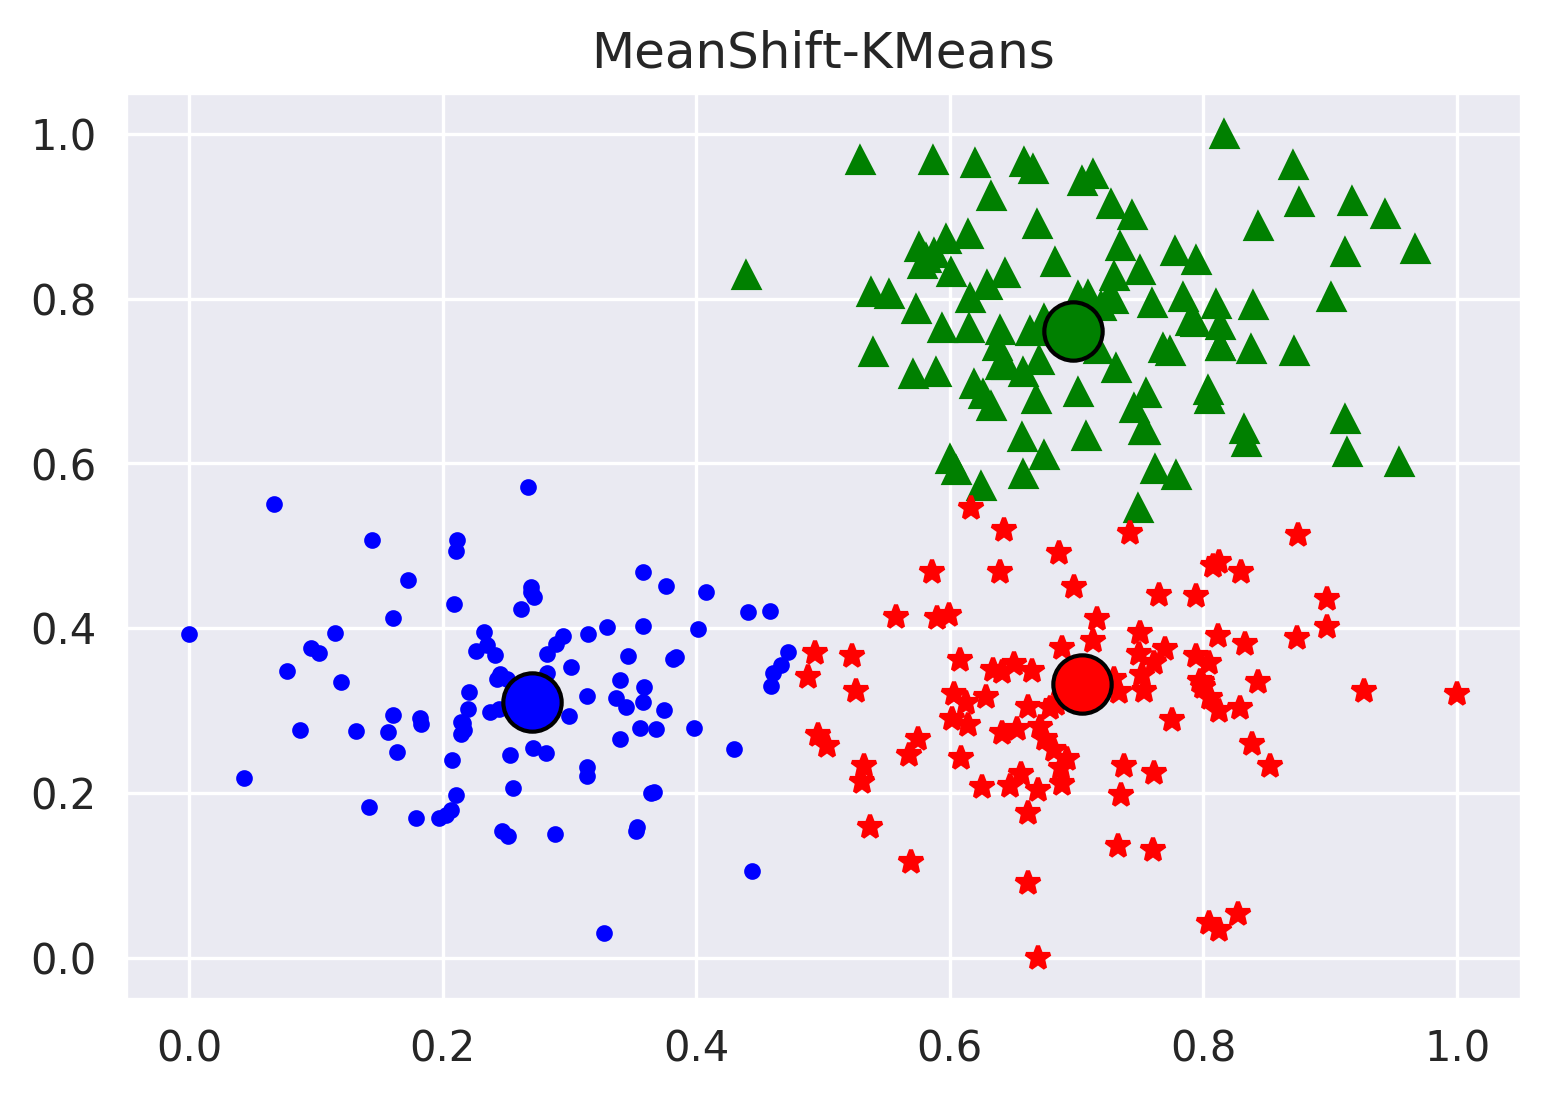

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False 

import seaborn as sns
sns.set_style("darkgrid",{"font.sans-serif":['simhei','Droid Sans Fallback']})
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 

from sklearn import metrics
from sklearn.cluster import KMeans, FeatureAgglomeration
from sklearn.decomposition import PCA, KernelPCA
from sklearn import random_projection
from sklearn import preprocessing
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

from itertools import cycle

class msk:
	def __init__(self,data,Standardized_method=['minmax',0,1],reduced_n_dim=None,reduced_method='PCA'):
		'''Parameters
		      - data: input "DataFrame"
		      - Standardized_method: input "list", the first element represents standardized method, including 'minmax'
		                             and 'zscore'; as for 'minmax', the second and third element represent down limit 
		                             and up limit of standardized interval.
		      - reduced_n_dim: input "int", manually determine how many dimension needed to be reduced, or automaticlly
		     	 			   decide how many principle components contributes over specific setting
		      - reduced_method: input "string", including 'PCA', 'FeatureAgglomeration', 'GaussianRandomProjection', 
		                        'SparseRandomProjection'
		'''

		self.data = pd.DataFrame(data)
		self.Standardized_method = Standardized_method
		self.reduced_n_dim = reduced_n_dim
		self.method = reduced_method
		self.cont_rate_list = [0.99, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70]


	def data_preprocessing(self):
		'''including data clearing, Standardization and transformation
		'''

		drop_list = []
		
		for ind in self.data.index.tolist():
			if pd.isnull(self.data.loc[ind][:]).all() == True \
			or pd.isnull(self.data.loc[ind][:]).any() == True:
				drop_list.append(ind)

		self.data.drop(drop_list,inplace=True) 

		print("  -  clear NULL data ")

		if self.Standardized_method[0] == 'minmax':
			print("  -  utilize MINMAX standardized method ")
			self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())
			self.data = self.data * (self.Standardized_method[2] - self.Standardized_method[1]) + self.Standardized_method[1]

		elif self.Standardized_method[0] == 'zscore':
			print("  -  utilize ZSCORE standardized method ")
			self.data = (self.data - self.data.mean()) / self.data.std()


	def dimension_reduction(self,cont_rate=0.99):
		'''Parameter
			  - cont_rate: contribution rates of each components used for determining how
			              many components are principle
		   Explanation
		      - firstly, determine "N" components contribute over 'cont_rate'	
		      - then use specific method make data dimension reduced to "N" 
		'''

		if not self.reduced_n_dim:

			pca = PCA(n_components=self.data.shape[1])
			pca.fit(self.data)
			pca_score = pca.explained_variance_ratio_

			for i in range(len(pca_score)):
				if sum(pca_score[:i+1]) >= cont_rate:
					n_components = i + 1
					break

			print("  -  The top-" + str(n_components) + " component(s) contribute(s) " + str(cont_rate*100) + "% ")

		else:
			n_components = self.reduced_n_dim

		print("  -  Choose top-" + str(n_components) + " component(s) as principle component(s) ")

		if self.method == 'PCA':
			print("  -  utilize 'PCA' dimensionality reduction method ")
			self.data = PCA(n_components=n_components).fit_transform(self.data)
			
		elif self.method == 'FeatureAgglomeration':
			print("  -  utilize 'FeatureAgglomeration' dimensionality reduction method ")
			self.data = FeatureAgglomeration(n_clusters=n_components).fit_transform(self.data)

		elif self.method == 'GaussianRandomProjection':
			print("  -  utilize 'GaussianRandomProjection' dimensionality reduction method ")
			self.data = random_projection.GaussianRandomProjection(n_components=n_components).fit_transform(self.data)

		elif self.method == 'SparseRandomProjection':
			print("  -  utilize 'SparseRandomProjection' dimensionality reduction method ")
			self.data = random_projection.SparseRandomProjection(n_components=n_components).fit_transform(self.data)

		self.data = pd.DataFrame(self.data)
		

	def mean_shift(self,isPlot=False):
		'''Parameters
		      - isPlot: plot or not
		'''

		print(" [*] starting MeanShift combind method ")

		self.data_preprocessing()
		print(" [*] data pre-processing done ")

		ind = 0
		while self.data.shape[1] > self.data.shape[0]:

			self.dimension_reduction(cont_rate=self.cont_rate_list[ind])

			if self.data.shape[1] > self.data.shape[0]:
				print("  -  reduced data dimension larger then data amount, alter another contribution rate ")
				ind += 1

			else:
				print("  -  reduced data dimension smaller then data amount ")
				break

		print(" [*] dimensionality reduction done ")

		X = np.array(self.data)
		bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=10000, random_state=42, n_jobs=2) 
		ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
		ms.fit(X)
		labels = ms.labels_
		cluster_centers = ms.cluster_centers_

		labels_unique = np.unique(labels)
		n_clusters_ = len(labels_unique)

		print(" [*] end ")

		if isPlot:
			plt.figure(1)
			plt.clf()
			colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')

			for k, col in zip(range(n_clusters_), colors):
				my_members = labels == k
				cluster_center = cluster_centers[k]
				plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
				plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
						markeredgecolor='k', markersize=14)

			plt.title('Mean-Shift Estimated number of clusters: %d' % n_clusters_)
			plt.show()


	def kmeans(self,n_cluster_list=list(range(2,10)),isPlot=False):
		''' Parameters
		       - n_cluster_list: list of cluster amounts for calculating different silhouette scores
		       - isPlot: plot or not
		    Explanation
		 	   - if having data clustered into known "N" classes, for example "N=3", then set 'n_cluster_list=[3]'
			   - if having no idea how many clusters should be decided, then give it a list with numbers you are
			     interested in, then select "N" with highest SILHOUETTE score 
		'''

		print(" [*] starting KMeans combind method ")

		self.data_preprocessing()
		print(" [*] data pre-processing done ")

		ind = 0
		while self.data.shape[1] > self.data.shape[0]:

			self.dimension_reduction(cont_rate=self.cont_rate_list[ind])

			if self.data.shape[1] > self.data.shape[0]:
				print("  -  reduced data dimension larger then data amount, alter another contribution rate ")
				ind += 1

			else:
				print("  -  reduced data dimension smaller then data amount ")
				break

		print(" [*] dimensionality reduction done ")

		np.random.seed(42)
		X = np.array(self.data) 

		if len(n_cluster_list) != 1:
			silhouette_avg = []
			for n in n_cluster_list:
				estimator = KMeans(init='random', n_clusters=n, max_iter=1000, n_init=10)
				cluster_labels = estimator.fit_predict(X)
				silhouette_avg.append(silhouette_score(X, cluster_labels))
				print("  -  For n_clusters = " + str(n) + ", the average silhouette_score is : " + str(silhouette_avg[-1]) + ".")

			n_samples, n_features = X.shape
			n_clusters = n_cluster_list[silhouette_avg.index(max(silhouette_avg))] #
			print("  -  Choose n_clusters = " + str(n_clusters) + " with max average silhouette score as final clusters number.")
			kmeans = KMeans(init='random', n_clusters=n_clusters, max_iter=1000, n_init=10)
			output_label = kmeans.fit_predict(X)
			cluster_centers = kmeans.cluster_centers_

		else:
			kmeans = KMeans(init='random', n_clusters=n_cluster_list[0], max_iter=1000, n_init=10)
			output_label = kmeans.fit_predict(X)
			cluster_centers = kmeans.cluster_centers_

		print(" [*] end ")

		if isPlot:
			plt.figure(1)
			plt.clf()
			colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
			plot_shape = list('.^*o+dp.^*o+dp.^*o+dp^*o+dp.^*o+dp.^*o+dp.^*o+dp.^*o+dp.^*o+dp.')

			for k, col in zip(list(set(output_label)), colors):
				my_members = output_label == k
				cluster_center = cluster_centers[k]
				plt.plot(X[my_members, 0], X[my_members, 1], col + plot_shape[k])
				plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
						markeredgecolor='k', markersize=14)
			plt.title('K-Means')
			plt.show()


	def combined(self,cluster_num=None,isPlot=False):
		'''Parameter
		      - cluster_num: input "int", manually determine number of clusters
		      - isplot: plot or not
		   Explanation
		      - utilize Mean-Shift method to make initial centroids of K-Means
		'''

		print(" [*] starting meanshift-kmeans combind method ")

		self.data_preprocessing()
		print(" [*] data pre-processing done ")

		ind = 0
		while self.data.shape[1] > self.data.shape[0]:

			self.dimension_reduction(cont_rate=self.cont_rate_list[ind])

			if self.data.shape[1] > self.data.shape[0]:
				print("  -  reduced data dimension larger then data amount, alter another contribution rate ")
				ind += 1

			else:
				print("  -  reduced data dimension smaller then data amount ")
				break

		print(" [*] dimensionality reduction done ")

		X = np.array(self.data)
		bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=10000, random_state=42, n_jobs=2) 
		ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
		ms.fit(X)
		labels = ms.labels_
		cluster_centers = ms.cluster_centers_

		labels_unique = np.unique(labels)
		n_clusters_ = len(labels_unique)

		dict_1 = []
		for i in labels:
			dict_1.append((i,str(i)))

		np.random.seed(42)
		data = np.array(cluster_centers) 

		if n_clusters_ > 2:
			if not cluster_num:

				range_n_clusters = list(range(2,n_clusters_))
				silhouette_avg = []

				for n in range_n_clusters:
					estimator = KMeans(init='random', n_clusters=n, max_iter=1000, n_init=10)
					cluster_labels = estimator.fit_predict(data)
					silhouette_avg.append(silhouette_score(data, cluster_labels))
					print("  -  For n_clusters = " + str(n) + ", the average silhouette_score is : " + str(silhouette_avg[-1]) + ".")

				# use K-Means to cluster Mean-Shift centroids
				n_digits = range_n_clusters[silhouette_avg.index(max(silhouette_avg))] #
				print("  -  Choose n_clusters = " + str(n_digits) + " with max average silhouette score as final clusters number.")
				kmeans = KMeans(init='random', n_clusters=n_digits, max_iter=1000, n_init=10)
				output_label = kmeans.fit_predict(data) 
				cluster_centers = kmeans.cluster_centers_

				# use clustered Mean-Shift centroids as initial centroids of K-Means
				kmeans = KMeans(init=cluster_centers, n_clusters=len(cluster_centers), max_iter=1000)
				output_label = kmeans.fit_predict(self.data) 

			else:
				# use K-Means to cluster Mean-Shift centroids
				kmeans = KMeans(init='random', n_clusters=min(cluster_num,n_clusters_), max_iter=1000, n_init=10)
				output_label = kmeans.fit_predict(data) 
				cluster_centers = kmeans.cluster_centers_

				# use clustered Mean-Shift centroids as initial centroids of K-Means
				kmeans = KMeans(init=cluster_centers, n_clusters=len(cluster_centers), max_iter=1000)
				output_label = kmeans.fit_predict(self.data) 

		else:
			output_label = labels

		print(" [*] end ")

		if isPlot and X.shape[1] >= 2:
			plt.figure(2)
			plt.clf()
			colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
			plot_shape = list('.^*o+dp.^*o+dp.^*o+dp^*o+dp.^*o+dp.^*o+dp.^*o+dp.^*o+dp.^*o+dp.')

			for k, col in zip(list(set(output_label)), colors):
				my_members = output_label == k
				cluster_center = cluster_centers[k]
				plt.plot(X[my_members, 0], X[my_members, 1], col + plot_shape[k])
				plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
						markeredgecolor='k', markersize=14)

			plt.title('MeanShift-KMeans')
			plt.show()

		dict_2 = {}
		for i in range(len(output_label)):
			dict_2.update({str(i):output_label[i]})

		new_labels = []
		for i in range(len(dict_1)):
			new_labels.append(dict_2[dict_1[i][1]])
		new_labels = np.array(new_labels).astype(int)

		labels_unique = np.unique(new_labels)
		n_clusters_ = len(labels_unique)

		new_labels_pd = pd.DataFrame(new_labels,index=self.data.index.tolist(),columns=['labels'])
		data_cluster_dict = {}
		output = pd.DataFrame(index=list(set(new_labels_pd['labels'])),\
							columns=self.data.columns)

		for label in set(new_labels_pd['labels']):
			a = list(new_labels_pd[(new_labels_pd['labels'] == label)].index)
			tmp = self.data.loc[a]
			for col in list(self.data.columns):
				output.loc[label][col] = tmp[col].mean()
				data_cluster_dict.update({label:a})

		if isPlot and X.shape[1] == 1:
			x = []
			for i in range(len(data_cluster_dict)):
				x.extend(data_cluster_dict[i])

			self.data = self.data.reindex(x)
			self.data = self.data.reset_index(drop=True)

			j = 0
			plot_shape = list('.^*o+dp.^*o+dp.^*o+dp^*o+dp.^*o+dp.^*o+dp.^*o+dp.^*o+dp.^*o+dp.')
			plot_color = list('bgrcmykbgrcmykbgrcmykbgrcmyk')
			for i in range(len(data_cluster_dict)):
				plt.plot(self.data.loc[j:j+len(data_cluster_dict[i])-1], color=plot_color[i], marker=plot_shape[i], \
					linestyle='', linewidth=2.0)
				j += len(data_cluster_dict[i])
			plt.show()

		return output, data_cluster_dict


if __name__ == '__main__':
	from sklearn.datasets.samples_generator import make_blobs
	centers = [[1, 1], [-1, -1], [1, -1]]
	X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5,
	                            random_state=0)
	obj = msk(X,Standardized_method=['minmax',0,1],reduced_n_dim=None,reduced_method='PCA')
	# obj.mean_shift(isPlot=True)
	# obj.kmeans(n_cluster_list=[4],isPlot=True)
	obj.combined(cluster_num=3,isPlot=True)